In [148]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import pandas as pd
from operator import itemgetter
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=10)

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Regression

## Table Of Content: <a id='toc'></a>

* [Introduction](#intro)

* [Data exploration](#Exploration)


* [Linear regression](#Linear-Regression)

    * [ML approach to linear regression - diabetes data](#LR-1)
    * [Adding regularization to the linear regression](#LR-regul)
    
* [KNN](#KNN)


* [SVM](#SVM)

* [Random Forest](#rf-r)

* [Gradient Boosting](#Gradient)

* [Exercise](#exo)


# Introduction : re-framing the target <a id='intro'></a>

In that part we will use all the algorithms seen previously but in the case of a regression rather than a classification.

**The difference is that now our target vector (i.e. what we want to predict) is not a class (a discrete variable) but rather a number that can take a continuity of values.**

The algorithms are going to use very similar methods than the ones used in classification (if there are particularities between using a method as a classifier and using the same method as a regressor I will mention it).

**What's mainly going to change is the loss function used to train your model and the scoring used to evaluate this model.**

**For classification** we saw two main types of **loss function**:

- Cross entropy (negative loglikelihood) : all the classifiers except SVM and KNN (because KNN doesn't learn through a loss function). Note : GINI impurity is a form of entropy.

- Hinge loss function : SVM classifier.

And plenty of **scoring systems**, but at least two in depth:

- Accuracy

- Area under the ROC curve.

Note that we could have used the value of the minimized loss function as a score. But for classification problems since the loss function can be different from one model to another, the values of the loss function can be hard to compare and you will prefer a scoring method independent of your loss function.

### In regression problems the loss functions and the scoring are metrics that you probably have seen before and so are more intuitive.

The **two main loss functions that you will minimize while training your model are** :


- Mean square error/ quadratic loss/ L2 loss **(MSE)** : $\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{n}$

- Mean absolute error/ L1 loss **(MAE)** : $\frac{\Sigma^{n}_{i=1}|y_{i}-\hat{y}_{i}|}{n}$

Where 
 * $n$ are the number of training examples
 * $i$ the $i$-th training example in the data set
 * $y_{i}$ the ground truth target value for that $i$-th example and 
 * $\hat{y_{i}}$ the estimated value of the target for the $i$-th example.

**Scoring to consider** here can actually be the value of the minimized loss function used (MSE or MAE) or other scoring metrics like :

- **R squared** : $1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}$

Proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model

- **Adjusted R squared** : $1-(1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}\frac{n-1}{n-(k+1)})$ , with k the degree of freedom.

Adjusted R-squared is similar to R-squared, but it takes into account the number of variables in the model.

- **Max error** : $max(|y_{i}-\hat{y}_{i}|)$

- **Variance explained** : $1-\frac{Var(\{y_{i}-\bar{y}_{i}\}_{i})}{Var(\{y_{i}\}_{i})}$

We will use the diabetes dataset to predict "*diabetes progression*" thanks to age, sex, body mass index, blood pressure and 6 blood serum measurements.

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

    Number of Instances: 442
    Number of Attributes: First 10 columns are numeric predictive values
    Target: Column 11 is a quantitative measure of disease progression one year after baseline
    Attribute Information
            age age in years
            sex
            bmi body mass index
            bp average blood pressure
            s1 tc, total serum cholesterol
            s2 ldl, low-density lipoproteins
            s3 hdl, high-density lipoproteins
            s4 tch, total cholesterol / HDL
            s5 ltg, possibly log of serum triglycerides level
            s6 glu, blood sugar level


In [149]:
# regression dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df_diabetes = pd.concat([pd.DataFrame(diabetes['data'],columns=diabetes['feature_names']),\
                       pd.DataFrame(diabetes['target'],columns=['disease progression'])],axis=1)

df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [150]:
# alternative way of loading which separates co-variables and target
(X_diabetes, y_diabetes) = load_diabetes(return_X_y = True)

print(X_diabetes[0:1,:],y_diabetes[0])

[[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990749 -0.01764613]] 151.0


In [151]:
df_diabetes.dtypes

age                    float64
sex                    float64
bmi                    float64
bp                     float64
s1                     float64
s2                     float64
s3                     float64
s4                     float64
s5                     float64
s6                     float64
disease progression    float64
dtype: object

[Back to ToC](#toc)

# A little bit on data exploration for regression <a class="anchor" id="Exploration"></a>

let's check how the different features and the target interact with each others.

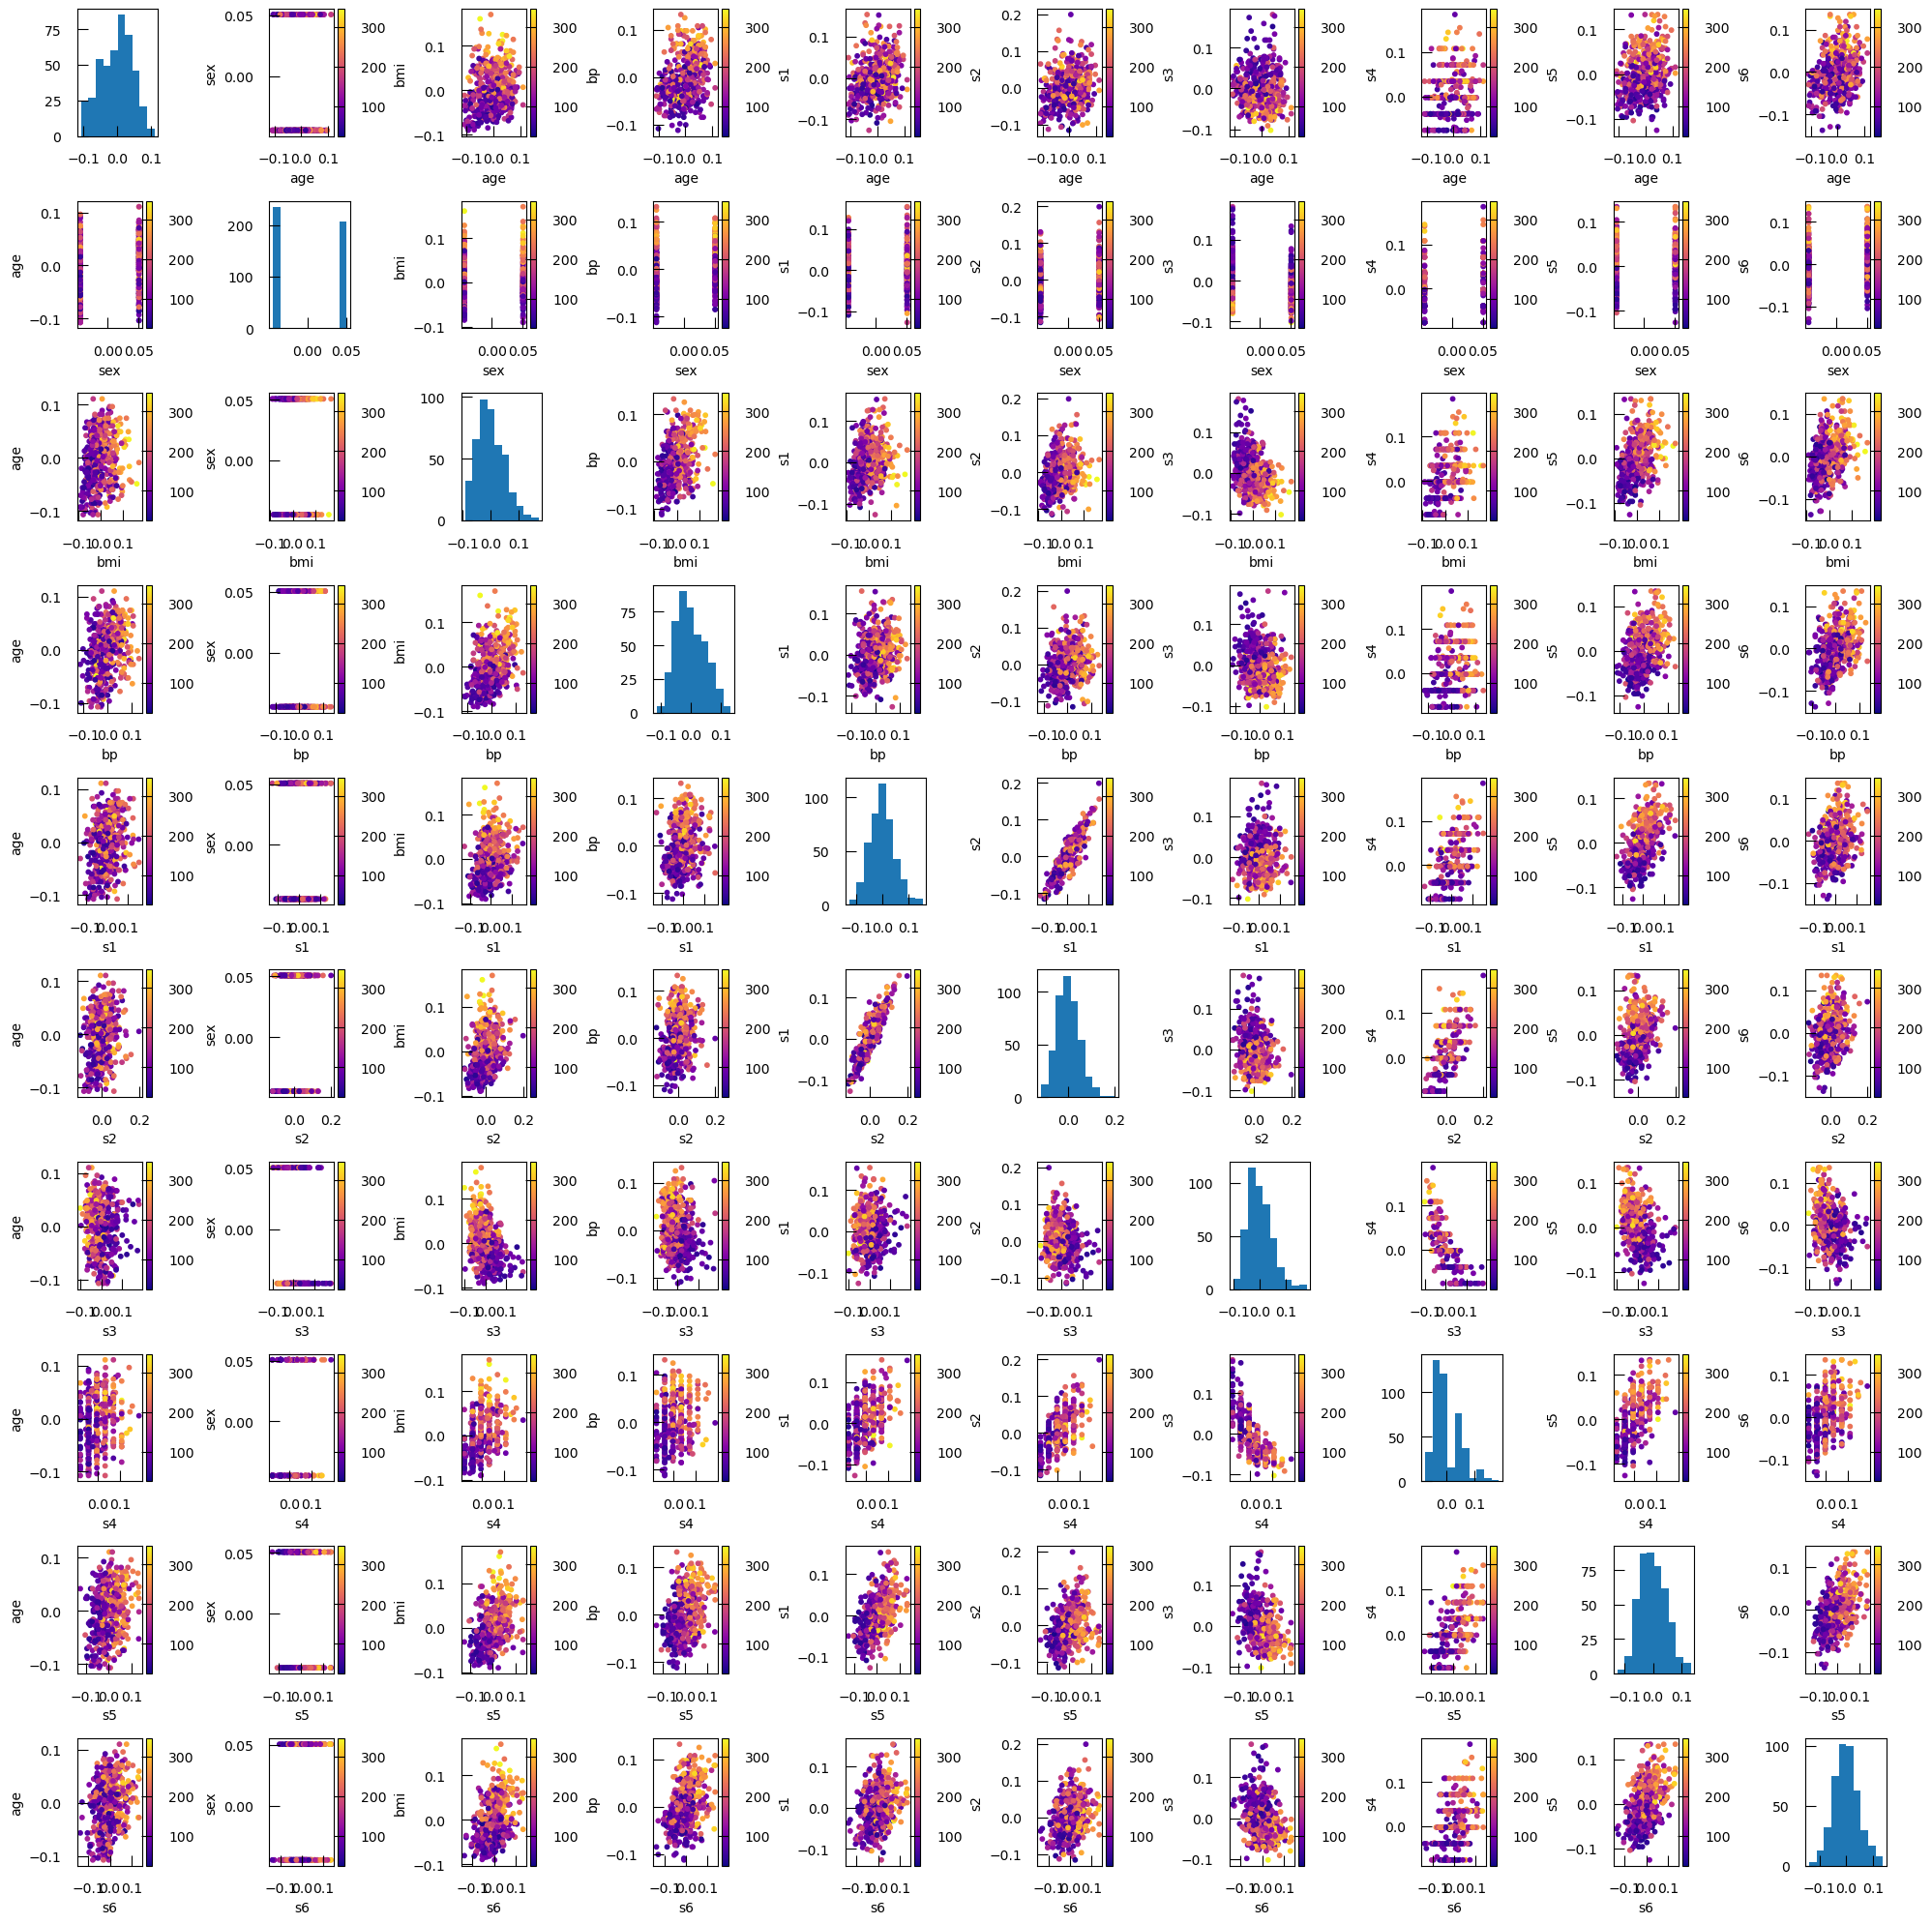

CPU times: user 10.4 s, sys: 837 ms, total: 11.2 s
Wall time: 10.3 s


In [152]:
%%time
plt.subplots(figsize=(20,20))
k=0
for v in diabetes.feature_names:
    for u in diabetes.feature_names:
        if v!=u:
            plt.subplot(len(list(df_diabetes.columns)[:-1]),len(list(df_diabetes.columns)[:-1]),k+1)
            plt.scatter(df_diabetes[v], df_diabetes[u], c=df_diabetes['disease progression'], s=10,cmap='plasma')
            plt.xlabel(v,fontsize=10)
            plt.ylabel(u,fontsize=10)
            plt.colorbar()
            k+=1
        else:
            plt.subplot(len(list(df_diabetes.columns)[:-1]),len(list(df_diabetes.columns)[:-1]),k+1)
            plt.hist(df_diabetes[v],10)
            k+=1
plt.tight_layout()
plt.show()

Another representation would be to look at the correlation

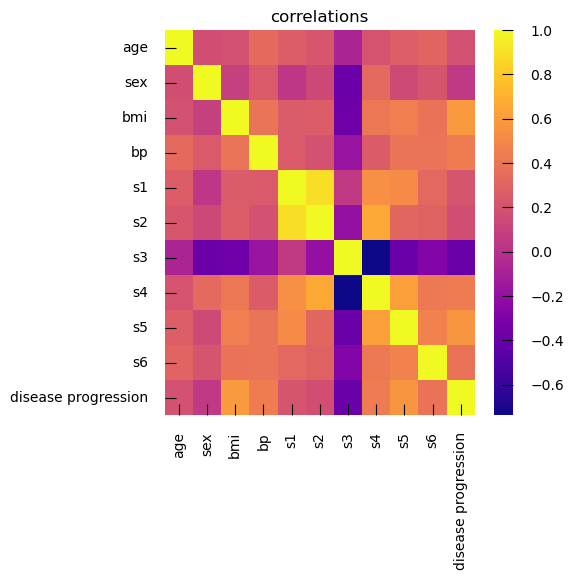

In [153]:
import pandas as pd
corre=df_diabetes.corr()
df_corr = pd.DataFrame(corre,columns=df_diabetes.columns)

plt.figure(figsize=(5,5))
sns.heatmap(df_corr,cmap='plasma')
plt.yticks(np.arange(0+0.5,len(df_corr.columns)+0.5,1),[v for v in df_corr.columns],rotation=0)
plt.title('correlations')
plt.show()

In [154]:
# ordered correlation between features and target
corre_arr=np.array(corre)[:,-1]
for fname,corr in sorted( zip( df_diabetes.columns[:-1] ,corre_arr )  ,key=itemgetter(1),reverse=True) :
    print("{}\t{:.3f}".format(fname,corr))

bmi	0.586
s5	0.566
bp	0.441
s4	0.430
s6	0.382
s1	0.212
age	0.188
s2	0.174
sex	0.043
s3	-0.395


We can already see here that `bmi` and `s5` are the two features that best correlate to our target disease progression.

We can choose other metrics to select the best features (i.e. perform features selection) using the `SelectKBest` function from Scikit-learn.
The `SelectKBest` method selects the features according to a score. By changing the `'score_func'` parameter we can apply the method for both classification and regression data. Selecting the best features is an important process when we prepare a large dataset for training. It helps us eliminate less important parts of the data and reduce training time.

We have the choice between calculating an F-score (`f_regression`) between a feature and the target.

> NB: An F-test is a way of comparing the significance of the improvement of a model, with respect to the addition of new variables. You can use it when you have a basic model $M_0$ and a more complicated model $M_1$, which contains all variables from $M_0$ and some more. The F-test tells you if $M_1$ is significantly better than $M_0$, with respect to a p-value.

If we think that there is no linear relationship between a feature and the target, we can estimate another score (`mutual_info_regression`).

> NB: **Mutual information** (MI) between two random variables is a non-negative value, which measures the dependency between the variables. 
It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

In [155]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# creating the SelectKBest object: looking for the best features (k=2) using the F score
skb = SelectKBest(f_regression, k=2)
# calculating the F score for each features
skb.fit(df_diabetes.iloc[:,:-1], df_diabetes["disease progression"])

featurePV = pd.DataFrame( {'feature': df_diabetes.columns[:-1],'pval':skb.pvalues_} )

# sort them by absolute value
featurePVsorted = featurePV.sort_values(by=['pval'] , 
                                      ascending=True )

# get the non-null ones
print('Features sorted per pvalue:')
featurePVsorted.loc[ featurePVsorted["pval"] <0.01 ]

Features sorted per pvalue:


,feature,pval
2,bmi,3.466006e-42
8,s5,8.826459e-39
3,bp,1.649372e-22
7,s4,2.304253e-21
6,s3,6.162865e-18
9,s6,7.580083e-17
4,s1,6.920712e-06
0,age,7.055686e-05
5,s2,2.359848e-04


In [156]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# creating the SelectKBest object: looking for the best features (k=2) using the MI
skb = SelectKBest(mutual_info_regression, k=2)
# calculating MI for each feature
skb.fit(df_diabetes[list(df_diabetes.columns)[:-1]], df_diabetes[list(df_diabetes.columns)[-1]])


# note that with F-score we are interested in small pvalues, whereas here we are interested in high MI score
# keep only the k=2 best features according to the score
X_new=skb.transform(df_diabetes[list(df_diabetes.columns)[:-1]])

featureMI = pd.DataFrame( {'feature': df_diabetes.columns[:-1],'MI':skb.scores_} )

# sort them by absolute value
featureMIsorted = featureMI.sort_values(by=['MI'] , 
                                      ascending=False )

# get the non-null ones
print('Features sorted per pvalue:')
featureMIsorted.loc[ featureMIsorted["MI"] >0.0 ]

Features sorted per pvalue:


,feature,MI
2,bmi,0.169562
8,s5,0.147485
7,s4,0.098351
9,s6,0.097368
4,s1,0.071092
6,s3,0.066192
1,sex,0.041673
3,bp,0.039891
5,s2,0.013281


As you can see, there are some differences between the two scores, probably coming from the variyng prominence of non-linear relationships between those features and our target.

[Back to the ToC](#toc)

# Linear regression <a class="anchor" id="Linear-Regression"></a>

In [157]:
# Toy data set where we have only one feature (X is one dimensional) and we want to predict y. 
# We use a simple model here: y is just a typical third degree polynomial of X with some gaussian noise 
# (here the coefficient of noise is set to 0.5 but I encourage you to play with it).

X=np.ndarray.reshape(np.arange(-1,1,10**-2),200,1)
print(np.shape(X))
y=[1-3*v+6*v**3 +0.5*np.random.randn() for v in X[:,0]]

(200, 1)


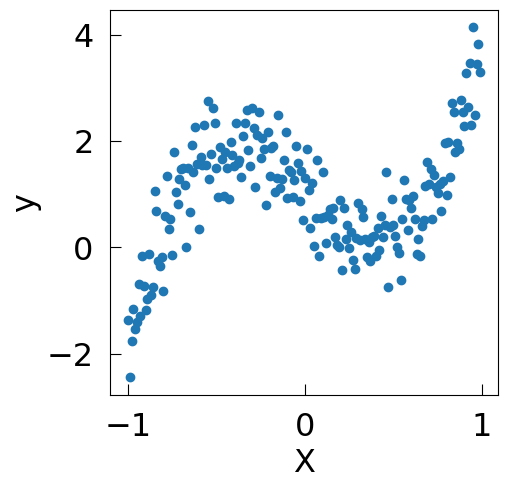

In [158]:
pylab.rcParams['figure.figsize'] =5, 5
plt.rc("font", size=23)
plt.plot(X[:,0],y,'o')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Let's start with a basic 1D linear regression that you know : 

We will fit our data with a model of the form y=aX+b and the fit will be done by minimizing the sum of squares of errors. 

We can evaluate the model either using a R-squared or even the mean square error directly. At first let's not put any regularization.

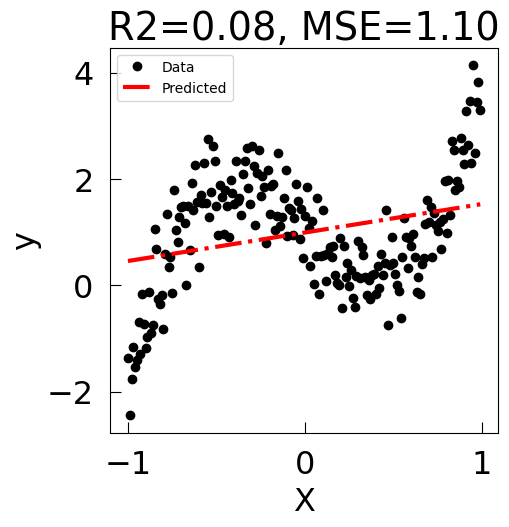

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

lr=LinearRegression()
lr.fit(X,y)
y_predict=lr.predict(X)
R2=r2_score(y,y_predict)
MSE=mean_squared_error(y,y_predict)

plt.plot(X[:,0],y,'ko',label='Data')
plt.plot(X[:,0],y_predict,'r-.',label='Predicted', linewidth = 3)
plt.legend(loc='best',fontsize=10)
plt.title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Ok so that's not great.... But we could have guessed that this model would be bad since it is clearly a third degree polynomial that links X to y. 

We can do better by using a 'trick' (actually it is a trick that we used before in SVM, and a trick that you can use in logistic regression too!!!). Let's artificially increase the number of dimension of our features set : we calculate $X^{2}$ and $X^{3}$ and consider them as features. 

After all a polynomial is just a linear combination of different monomials.

$y=wX +b$ is a linear combination of X

$y=w_{1}X+w_{2}X^{2}+w_{3}X^{3}$ is still a linear combination of feature X, $X^{2}$ and $X^{3}$

You can call `from sklearn.preprocessing import PolynomialFeatures` and it will do all those X transformations for you. 
You might think it is a little bit unecessary to call a function for that, but wait to see when we will have to do the same in higher dimensions.

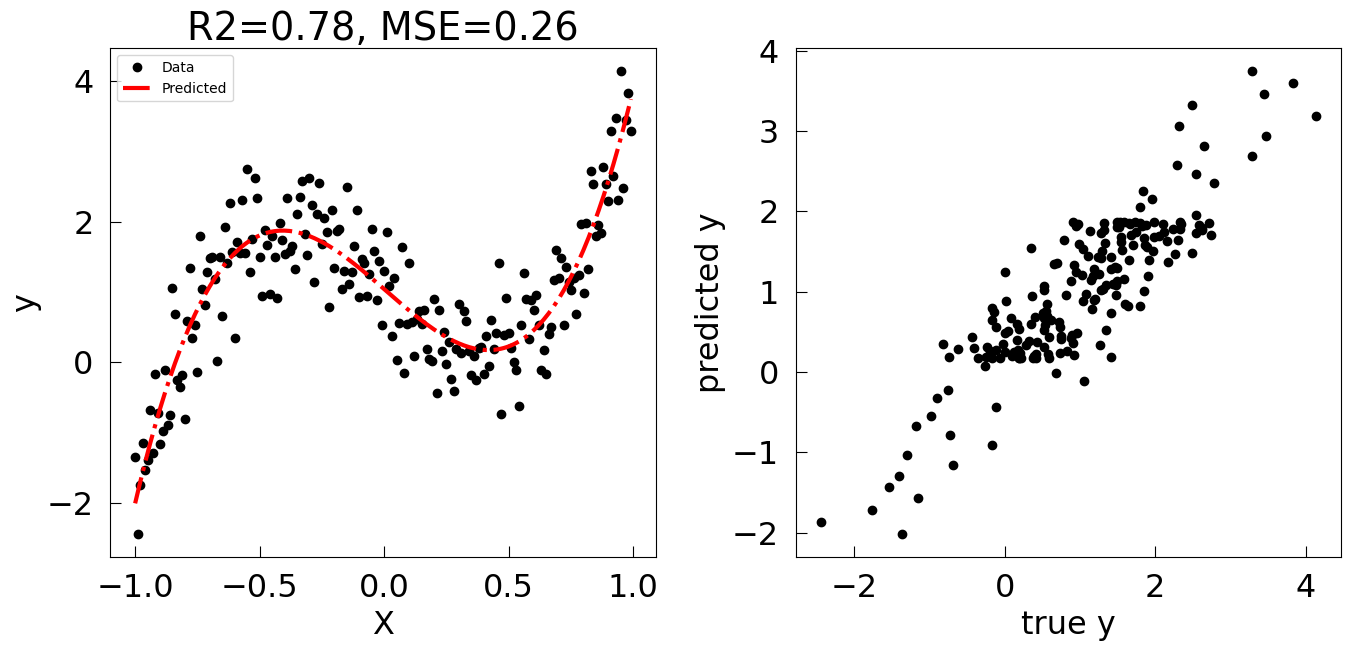

fit param [ 0.         -3.08997613 -0.09844435  6.0411866 ] 1.0377606990418602
true param [0, -3, 0, 6] 1


In [160]:
from sklearn.preprocessing import PolynomialFeatures

# here we set a third degree polynomial object
poly = PolynomialFeatures(degree=3)
# do the actual fit and transformation of data
X_poly=poly.fit_transform(X)


lr=LinearRegression()
lr.fit(X_poly,y)
y_predict=lr.predict(X_poly)
R2=r2_score(y,y_predict)
MSE=mean_squared_error(y,y_predict)

fig,ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(X[:,0],y,'ko',label='Data')
ax[0].plot(X[:,0],y_predict,'r-.', linewidth=3,label='Predicted')
ax[0].legend(loc='best',fontsize=10)
ax[0].set_title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')


ax[1].plot(y,y_predict,'ko')
ax[1].set_xlabel('true y')
ax[1].set_ylabel('predicted y')

plt.tight_layout()
plt.show()
print('fit param',lr.coef_,lr.intercept_)
print('true param',[0,-3,0,6],1)

Now you can actually do the same for more initial features: let's see with a 2D problem

In [161]:
# the function is a multivariate (2D) polynomial of degree 3 : that's 10 coefficients....
# Here I put the noise to 100 but please play with that number 
# to see how it affects your data and the model predicitions.

X2=np.ndarray.reshape(np.random.uniform(-5,5,400),200,2)


u = X2[:,0]
v = X2[:,1]
noise = 100


y2=4*v+u+2*v**2+0.5*v*u-1*u**2+6*v**3-0.5*v**2*u+4*v*u*u+5*u**3 +4 +noise*np.random.randn(X2.shape[0])


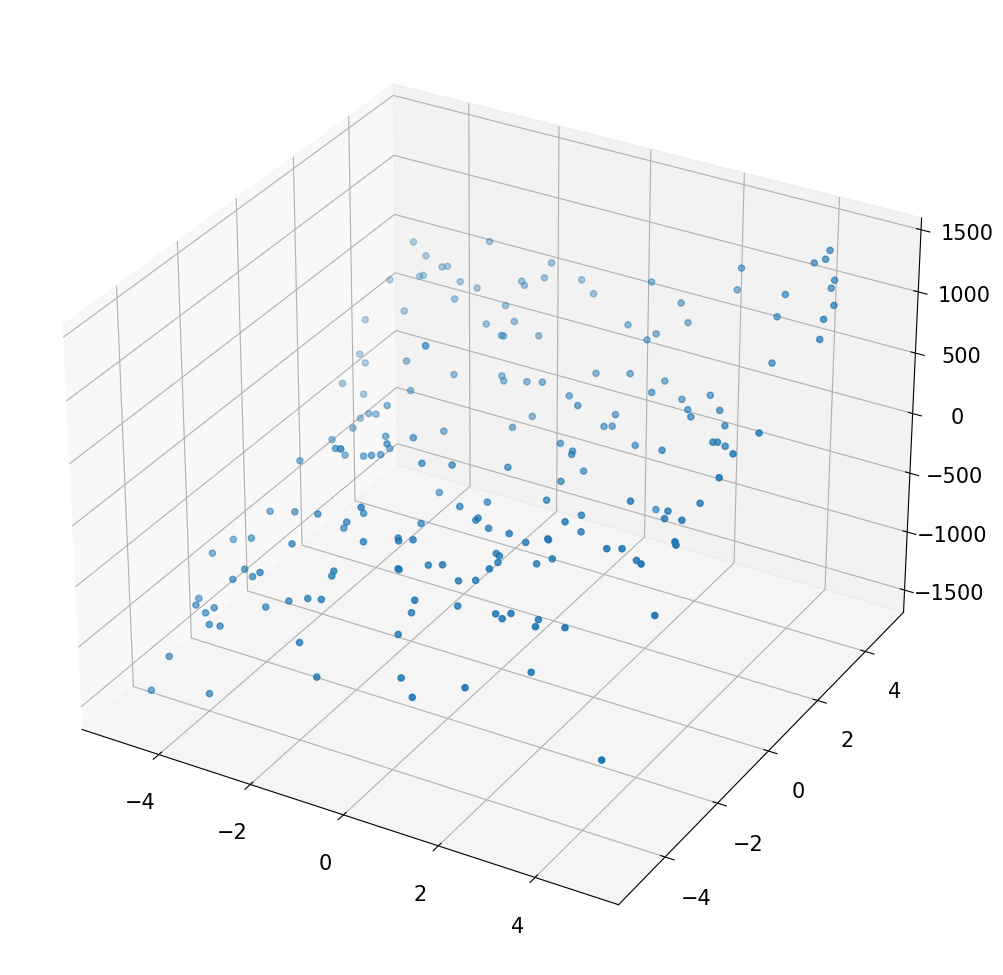

In [162]:
from mpl_toolkits.mplot3d import Axes3D
plt.rc("font", size=15)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c=None, depthshade=True)
plt.tight_layout()
plt.show()

In [163]:
## or rather, if you have plotly
import plotly.express as px

px.scatter_3d( x =  X2[:,0], y=X2[:,1], z=y2 , size=[1]*y2.shape[0])


The order of polynomials coefficient according to the feature power.
For example, [1 0] is our seconde monomial and stand for X1.
[1 1] is our 5th monomial and stand for X1*X2
[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]
fit param [ 0.         14.00348219 12.92413368  0.18920429  0.47627165  0.5246274
  4.21367267  3.93412443 -0.49865069  5.62055807] 5.391237534930966
true param [[0, 4, 1, 2, 0.5, -1, 6, -0.5, 4, 5], 4]


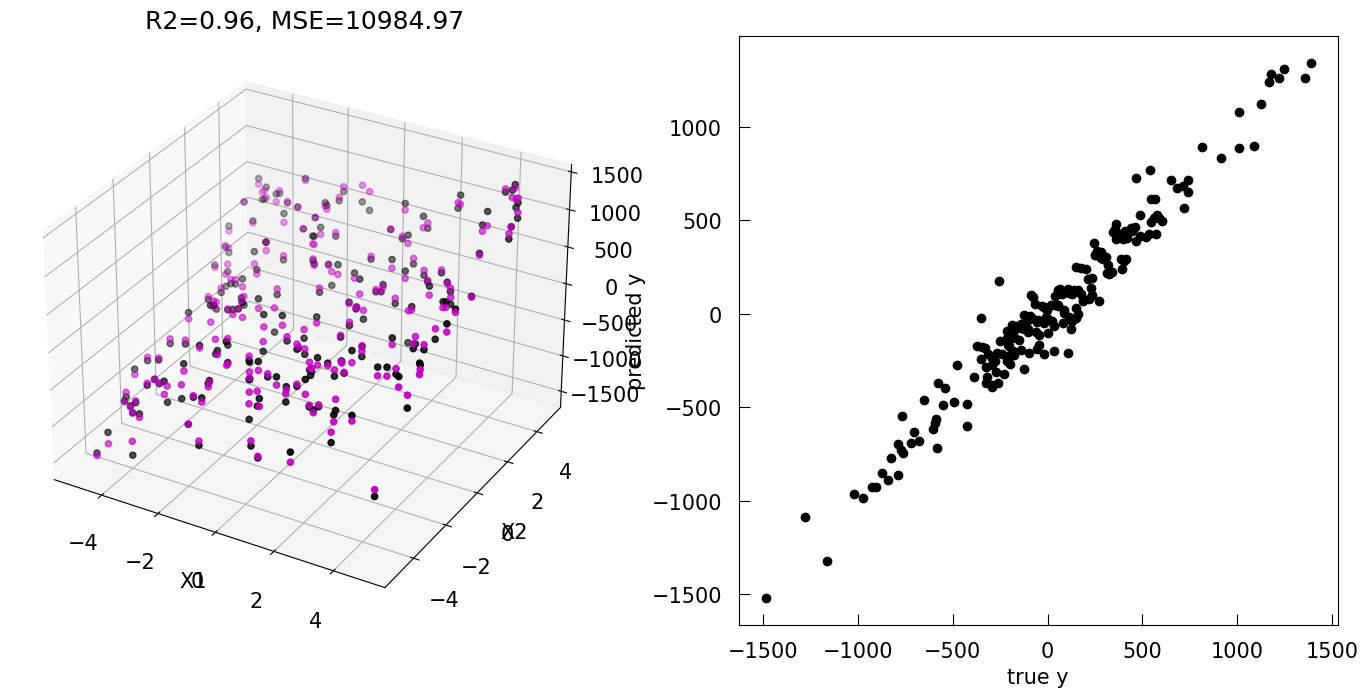

In [164]:
poly = PolynomialFeatures(degree=3)

X_poly=poly.fit_transform(X2)
print('The order of polynomials coefficient according to the feature power.') 
print('For example, [1 0] is our seconde monomial and stand for X1.')
print('[1 1] is our 5th monomial and stand for X1*X2')
print(poly.powers_)

lr=LinearRegression()
lr.fit(X_poly,y2)
y_predict=lr.predict(X_poly)
R2=r2_score(y2,y_predict)
MSE=mean_squared_error(y2,y_predict)


fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c='k', depthshade=True)
ax.scatter(X2[:,0],X2[:,1],y_predict ,color='m')
ax.set_title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax = fig.add_subplot(122)
ax.plot(y2,y_predict,'ko')
ax.set_xlabel('true y')
ax.set_ylabel('predicted y')

plt.tight_layout()

print('fit param',lr.coef_,lr.intercept_)
print('true param',[[0,4,1,2,0.5,-1,6,-0.5,4,5],4])

In [165]:
## or rather, if you have plotly
import plotly.express as px
import plotly.graph_objects as go

## make a grid of point to make a surface repr4esenting the model predictions
xi = np.linspace(X2[:,0].min(), X2[:,0].max(), 100)
yi = np.linspace(X2[:,0].min(), X2[:,0].max(), 100)

Xgrid,Ygrid = np.meshgrid(xi,yi)
Zgrid=lr.predict( poly.transform(np.stack( (Xgrid.flatten() , Ygrid.flatten()) , axis = 1 )) ).reshape( 100,100 )

## plotting 
trace1 = go.Scatter3d(  x =  X2[:,0], y=X2[:,1], z=y2,
                        mode='markers',name='data')

trace2 = go.Surface(x=xi,y=yi,z=Zgrid , name='model')

fig = go.Figure(data=[trace1, trace2])
fig

In this case the function we are fitting is the following:

$y=w_{1}X_{1}+w_{2}X_{2}+w_{3}X_{1}^{2}+w_{4}X_{1}X_{2}+w_{5}X_{2}^{2}+w_{6}X_{1}^{3}+w_{7}X_{1}^{2}X_{2}+w_{8}X_{1}X_{2}^2+w_{9}X_{2}^{3}+b$

So you see that by artificially increasing the number of dimensions of your data you can bring some non linear feature fit into the game and expand your set of models to explore. The only thing you have to do is to consider monomials as features (polynomial feature will compute them for you). 

[Back to the ToC](#toc)

## ML approach to linear regression - diabetes data <a id='LR-1'></a>

Now you can already see that the polynomial transformation of your data brings an hyperparameter to be chosen. So we will have to use a pipeline that transforms our data into polynomials of different degree before feeding it to the linear regression, and that pipeline will then be used to find the good polynomial degree thanks to `GridSearchCV`.

In [166]:
help( PolynomialFeatures )

Help on class PolynomialFeatures in module sklearn.preprocessing._polynomial:

class PolynomialFeatures(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  PolynomialFeatures(degree=2, *, interaction_only=False, include_bias=True, order='C')
 |  
 |  Generate polynomial and interaction features.
 |  
 |  Generate a new feature matrix consisting of all polynomial combinations
 |  of the features with degree less than or equal to the specified degree.
 |  For example, if an input sample is two dimensional and of the form
 |  [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
 |  
 |  Read more in the :ref:`User Guide <polynomial_features>`.
 |  
 |  Parameters
 |  ----------
 |  degree : int or tuple (min_degree, max_degree), default=2
 |      If a single int is given, it specifies the maximal degree of the
 |      polynomial features. If a tuple `(min_degree, max_degree)` is passed,
 |      then `min_degree` is the minimum and `max_degree` is the maximum
 |

In [167]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from operator import itemgetter

X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(X_diabetes, y_diabetes,
                                                                                        random_state=794182)

lr=LinearRegression()

pipeline_lr=Pipeline([('poly',PolynomialFeatures()),('scalar',StandardScaler()),('model',lr)])


# define the hyperparameters you want to test with their range to be tested
grid_values = {'poly__degree': np.arange(1,4,1),
               'poly__interaction_only':[False,True]}

# Feed them to GridSearchCV with the right score (R squared)
grid_lr_acc = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='r2')

grid_lr_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_lr_acc.score(X_diabetes_test,y_diabetes_test)


print('Grid best parameter (max. r2): ', grid_lr_acc.best_params_)
print('Grid best score (r2): ', grid_lr_acc.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)

Grid best parameter (max. r2):  {'poly__degree': 1, 'poly__interaction_only': False}
Grid best score (r2):  0.4682835662453423
Grid best parameter (max. r2) model on test:  0.5646518104686494
CPU times: user 565 ms, sys: 1.13 s, total: 1.69 s
Wall time: 235 ms


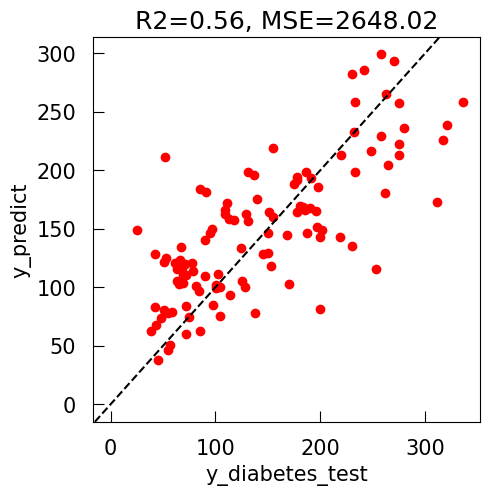

In [168]:
lrm = grid_lr_acc.best_estimator_
y_predict = lrm.predict(X_diabetes_test)

R2=r2_score(y_diabetes_test,y_predict)
MSE=mean_squared_error(y_diabetes_test,y_predict)


plt.plot(y_diabetes_test,y_predict,'ro',label='Predicted', linewidth = 3)
plt.title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
plt.axline((0, 0), slope=1, color="black", linestyle='dashed')
plt.xlabel('y_diabetes_test')
plt.ylabel('y_predict')
plt.show()

In [169]:
poly = grid_lr_acc.best_estimator_.steps[0][1]
LR = grid_lr_acc.best_estimator_.steps[2][1]

def pow2name(power, fnames=diabetes['feature_names'] ):
    n = []
    for i,j in enumerate(power):
        if j>0:
            n.append( fnames[i]+'^'+str(j) )
    return "_".join(n)
    
sorted_list=sorted( zip( map( pow2name , poly.powers_) , LR.coef_ ) ,key=itemgetter(1),reverse=True)
print('model importances')
for f,w in sorted_list:
    print("{}\t{:.2f}".format(f,w))

model importances
s5^1	32.14
bmi^1	25.87
bp^1	14.52
s2^1	11.73
s4^1	5.19
s6^1	2.84
	0.00
age^1	-0.60
s3^1	-0.83
sex^1	-11.05
s1^1	-25.63


[Back to the ToC](#toc)

## Let's add some regularization <a id="LR-regul"></a>

Ridge and Lasso regularizations are also known as **‘shrinkage’** methods, because they reduce or shrink the coefficients in the resulting regression. 
This reduces the variance in the model: as input variables are changed, the model’s prediction changes less than it would have without the regularization. 

Why would you want to reduce the variance of a model? To **avoid overfit**.

In [170]:
%%time
from sklearn.linear_model import SGDRegressor

# Linear model fitted by minimizing a regularized empirical loss with 
# SGD (Stochastic gradient Descent)
# You can change the loss function and the learning rate. 
# But we will not mess with that here.
# The learning rate adjustment is made in a clever way by default
# and we will stick to the MSE loss.
lr_reg=SGDRegressor()

pipeline_lr_reg=Pipeline([('poly',PolynomialFeatures()),
                          ('scalar',StandardScaler()),
                          ('model',lr_reg)])

from sklearn.model_selection import GridSearchCV

# define the hyperparameters you want to test with their range 
# Regularization shrinks the coefficient estimates towards zero
# l1: Lasso regularization adds another term to the cost function, representing the sum of 
# the magnitudes of all the coefficients in the model.
# l2: Ridge regression follows the same pattern, but the penalty term is the sum of the coefficients squared.

# Here alpha is the weight for the regularization: the higher the value, the stronger the regularization
grid_values = {'poly__degree': np.arange(1,4,1),
               'poly__interaction_only':[False,True],
               'model__penalty':['l1','l2'],
               'model__alpha':np.logspace(0,3,10)}

# Feed them to GridSearchCV with the right score (R squared)
grid_lr_reg_acc = GridSearchCV(pipeline_lr_reg, 
                               param_grid = grid_values, scoring='r2')

grid_lr_reg_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_lr_reg_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_lr_reg_acc.best_params_)
print('Grid best score (r2): ', grid_lr_reg_acc.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)

Grid best parameter (max. r2):  {'model__alpha': 2.154434690031884, 'model__penalty': 'l1', 'poly__degree': 2, 'poly__interaction_only': True}
Grid best score (r2):  0.4736423814742328
Grid best parameter (max. r2) model on test:  0.5518304861466401
CPU times: user 9.98 s, sys: 25.3 s, total: 35.3 s
Wall time: 5.3 s


In [171]:
poly = grid_lr_reg_acc.best_estimator_.steps[0][1]
LR = grid_lr_reg_acc.best_estimator_.steps[2][1]

def pow2name(power, fnames=diabetes['feature_names'] ):
    n = []
    for i,j in enumerate(power):
        if j>0:
            if j>1:
                n.append( fnames[i]+'^'+str(j) )
            else:
                n.append( fnames[i])
    return "_".join(n)
    

O = np.argsort( np.abs( LR.coef_ ) )
coef_list= list( zip( map( pow2name , poly.powers_) , LR.coef_ ) )
sorted_list = [ coef_list[i] for i in O[::-1] ]
print('model importances')
for f,w in sorted_list:
    if w !=0:
        print("{:>20}\t{:>5.2f}".format(f,w))

model importances
                 bmi	24.51
                  s5	22.24
                  bp	12.00
                  s3	-9.20
             age_sex	 7.67
                 sex	-7.19
              bmi_bp	 6.63
              sex_s3	 2.87
              age_bp	 2.58
               s1_s4	-2.39
              age_s6	 1.70
                  s6	 1.26
                  s2	-1.12
              bmi_s4	 1.07
               s1_s3	 0.74
               s4_s6	 0.67
              sex_bp	 0.41
              age_s2	-0.15
              sex_s6	 0.09


<br>

Here,  with an artificial example we can **illustrate how regularization can rescue linear regression when feature vectors are strongly correlated**. 

First let's investigate how adding highly correlated features changes the error in linear regression:

In [172]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

lr=LinearRegression()

X_train = X_diabetes_train
y_train = y_diabetes_train 
X_test = X_diabetes_test
ncol = X_train.shape[1]

#first, our "stable" model, with the original data
lrm = lr.fit(X_train, y_diabetes_train)

y_pred_stable = lrm.predict(X_test)

#second, we create an "unstable" dataset, 
# where we add columns with are highly correlated with existing columns
# ie, dependent = existing_column + some normal noise
X_train_u = pd.DataFrame(X_diabetes_train)
X_test_u = pd.DataFrame(X_diabetes_test)
for i in np.arange(100):
    j = np.random.randint(ncol)
    X_train_u['Dependent_{0}'.format(i)] = X_train_u.iloc[:,j] + np.random.normal(0, X_train_u.iloc[:,j].std()/100000, X_train_u.shape[0])
    X_test_u['Dependent_{0}'.format(i)] = X_test_u.iloc[:,j] + np.random.normal(0, X_test_u.iloc[:,j].std()/100000, X_test_u.shape[0])
    
    ## the following 2 lines are specific to cases where we add a lot of columns to a 
    ## pandas dataFrame. To keep it simple : calling copy re-indexes the columns 
    X_train_u = X_train_u.copy()
    X_test_u = X_test_u.copy()
    
X_train_u = X_train_u.to_numpy()
X_test_u = X_test_u.to_numpy()
y_train = y_diabetes_train 
print(X_train_u.shape)
print(X_test_u.shape)

(331, 110)
(111, 110)


In [173]:
# we then fit this "unstable" model
lrm = lr.fit(X_train_u, y_diabetes_train)

y_pred_unstable = lrm.predict(X_test_u)

print('error (stable):   {:.1f}'.format(mean_squared_error(y_diabetes_test, y_pred_stable)))
print('error (unstable): {:.1f}'.format(mean_squared_error(y_diabetes_test, y_pred_unstable)))

error (stable):   2648.0
error (unstable): 4567.6


As you can see, the presence of the correlated variables causes an increase in the model's performance (mean standard error here).

<br>

Now let's see how we can use Ridge regularization to improve linear regression, when feature vectors are strongly correlated.

Equivalently you could also use lasso or elastic net regularization.

In [174]:
## fit the stable model
rdg=Ridge()
lr=LinearRegression()

rdgm = rdg.fit(X_train_u, y_diabetes_train)

y_pred_unstable_ridge = rdgm.predict(X_test_u)

print('error (unstable-ridge): {:.1f}'.format(mean_squared_error(y_diabetes_test, y_pred_unstable_ridge)))

error (unstable-ridge): 2679.0


We can see that the ridge regression allows us to find back something close we what we had without the correlated variables 

[Back to the ToC](#toc)

# KNN <a class="anchor" id="KNN"></a>

You can also use the KNN algorithm for regression.
Again you get the K nearest neighbors of the point you want to predict but this time instead of a vote it does a local average of the neighbours value (again weighted or not by their distance to your query point).

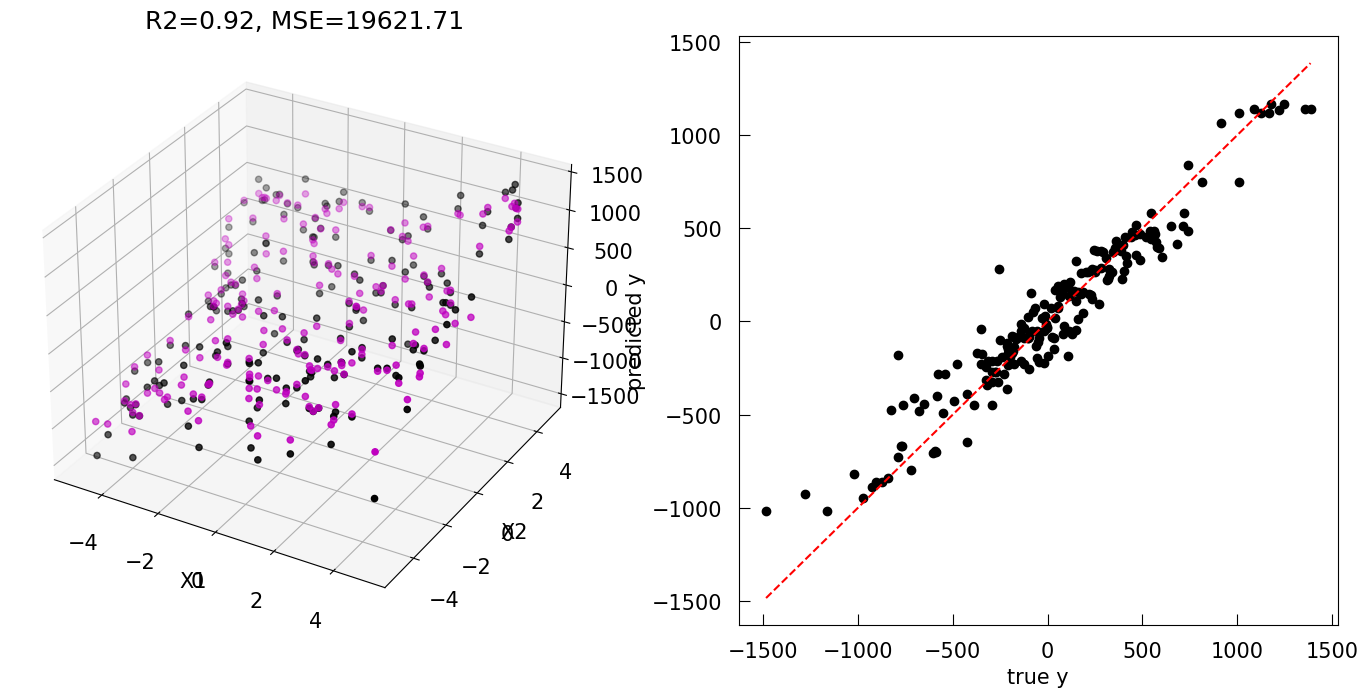

In [175]:
from sklearn.neighbors import KNeighborsRegressor

knn=KNeighborsRegressor(n_neighbors=10)
knn.fit(X2,y2)
y_predict=knn.predict(X2)
R2=r2_score(y2,y_predict)
MSE=mean_squared_error(y2,y_predict)



fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c='k', depthshade=True)
ax.scatter(X2[:,0],X2[:,1],y_predict ,color='m')
ax.set_title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax = fig.add_subplot(122)
ax.plot(y2,y_predict,'ko')
m = min(min(y2),min(y_predict))
M = max(max(y2),max(y_predict))
ax.plot([m,M],[m,M],'r--')
ax.set_xlabel('true y')
ax.set_ylabel('predicted y')

plt.tight_layout()


KNN regressor is not really good at predicting sparse neigborhoods (the predictions for the extreme data points are not accurate).

[Back to the ToC](#toc)

# SVM <a class="anchor" id="SVM"></a>

In SVM regression the algo is almost the same as classifier SVM with one big difference. In classification we were looking at the hyperplane that was as far as possible from our support vectors.
In regression you look for the **hyperplanes that are as close as possible from your support vector**.

> NB: **Support vectors** are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. 


In [176]:
from sklearn.svm import SVR

svr=SVR()

pipeline_svr=Pipeline([('scalar',StandardScaler()),('model',svr)])

from sklearn.model_selection import GridSearchCV

# define the hyperparameters you want to test with their range
# kernel: kernel type to be used in the algorithm (function that takes low dimensional input space 
# and transforms it to a higher dimensional space)
# degree: degree of the polynomial kernel function
# epsilon: parameters that controls which data points contribute to regularization
# C: inverse of regularization strength
grid_values = [{"model": [SVR(kernel='linear')],
                 "model__C":np.logspace(-2, 2, 10)},
                {"model": [SVR(kernel='rbf')],
                 "model__gamma": np.logspace(-2,1,10)},
                {"model": [SVR(kernel='poly')],
                 "model__C":np.logspace(-2, 2, 10),
                 "model__degree":np.arange(2,10,1)}]

# Feed them to GridSearchCV with the right score (R squared)
grid_svr_acc = GridSearchCV(pipeline_svr, param_grid = grid_values, scoring='r2')

grid_svr_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_svr_acc.score(X_diabetes_test,y_diabetes_test)


print('Grid best parameter (max. r2): ', grid_svr_acc.best_params_)
print('Grid best score (r2): ', grid_svr_acc.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)

Grid best parameter (max. r2):  {'model': SVR(C=1.6681005372000592, kernel='linear'), 'model__C': 1.6681005372000592}
Grid best score (r2):  0.46396630381267767
Grid best parameter (max. r2) model on test:  0.5519849098247014


In [177]:
best_kernel = grid_svr_acc.best_estimator_.steps[1][1].kernel
if best_kernel=='linear':
    
    svr = grid_svr_acc.best_estimator_.steps[1][1]
    
    featureW = pd.DataFrame( {'feature' : diabetes['feature_names'],
                                'weight': svr.coef_.flatten()} )

    # sort them by absolute value
    featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

    # get the non-null ones
    print('Features sorted per importance:')
    print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )

    

Features sorted per importance:
  feature     weight
2     bmi  22.730273
8      s5  21.056282
3      bp  19.255008
1     sex -14.743769
6      s3 -10.238319
5      s2  -6.598145
4      s1  -4.368385
9      s6   3.733290
7      s4   3.226927
0     age  -1.698126


<br>

[Back to the ToC](#toc)

<br>

## Random Forest <a class="anchor" id="rf-r"></a>

From the standpoint of tree, the only difference is that now, instead of the entropy or Gini criterion, **the decision which variable to use at any node is made using a regression metric**, such as squared error for example.

For example, consider this example of [regression with a single tree](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html), adapted from the sklearn website:

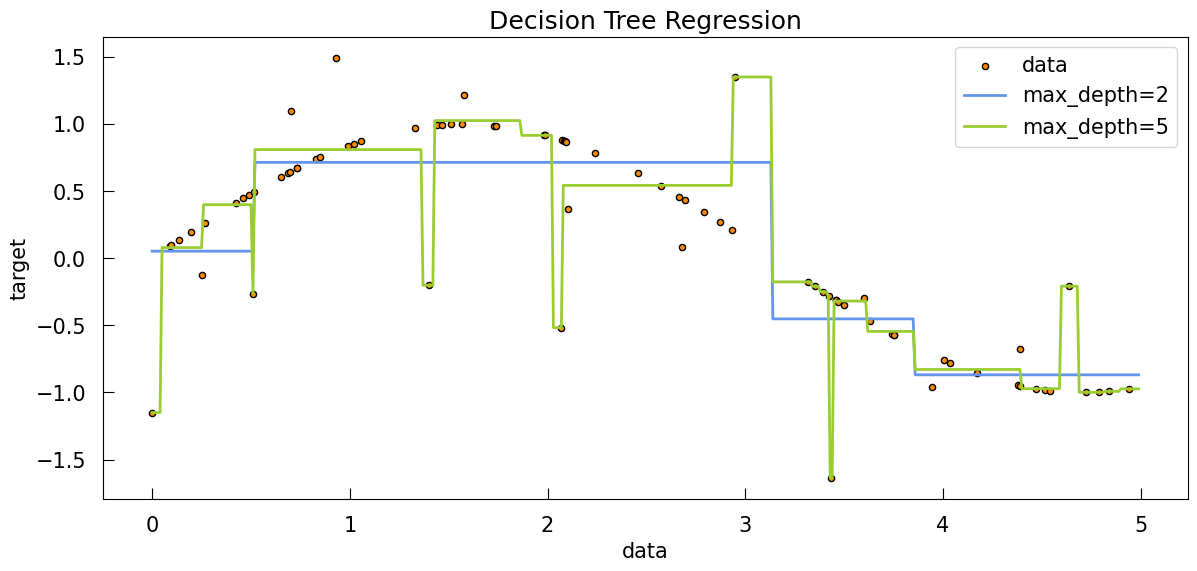

In [178]:
from sklearn.tree import DecisionTreeRegressor
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16)) # adding additional noise to some of the points

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


Text(0.5, 1.0, 'best single decision tree')

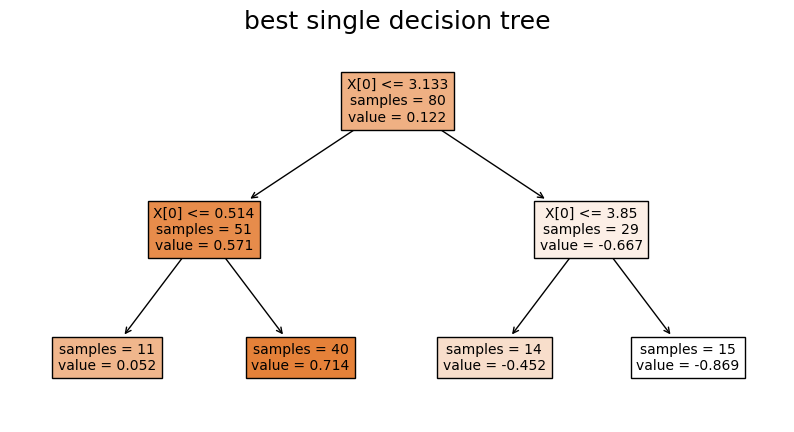

In [179]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(10,5))
plot_tree( regr_1 , 
          ax=ax , fontsize=10 , filled=True , impurity=False , precision=3)
ax.set_title('best single decision tree')

Of course with a single tree you do not get very far, unless the tree becomes absolutely huge. 

But with a random forest you can aggregate the estimate from many trees to get somewhere nice.

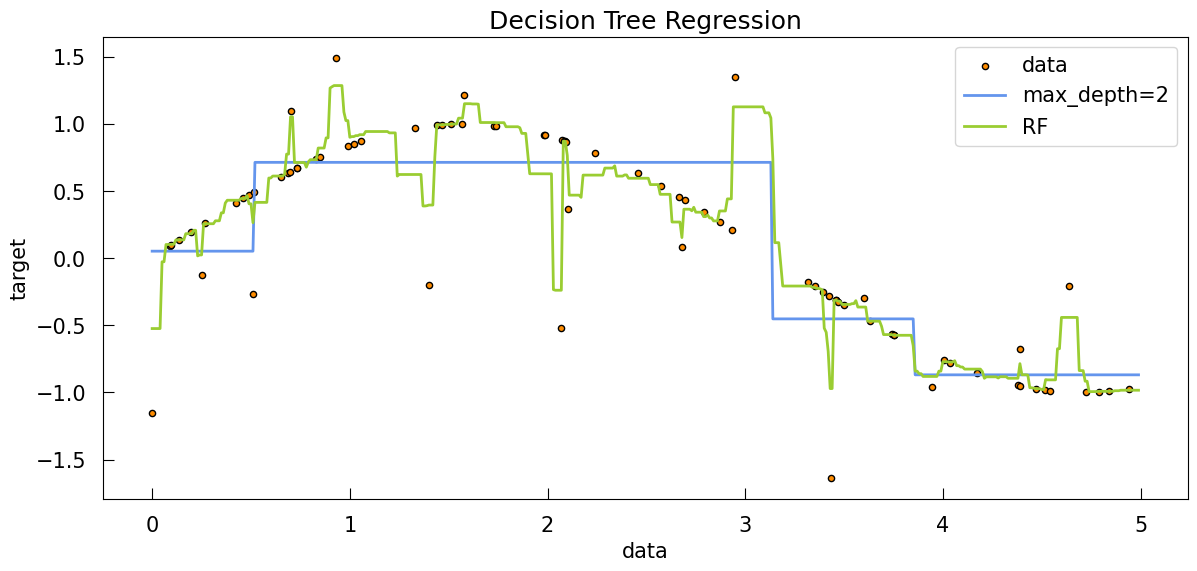

In [180]:
from sklearn.ensemble import RandomForestRegressor

RFReg = RandomForestRegressor(n_estimators=10 )
RFReg.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_rf = RFReg.predict(X_test)

# Plot the results
plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()



With a bit of leg-work, we can even grab the inidividual trees predictions to build an interval around the random forest prediction: 

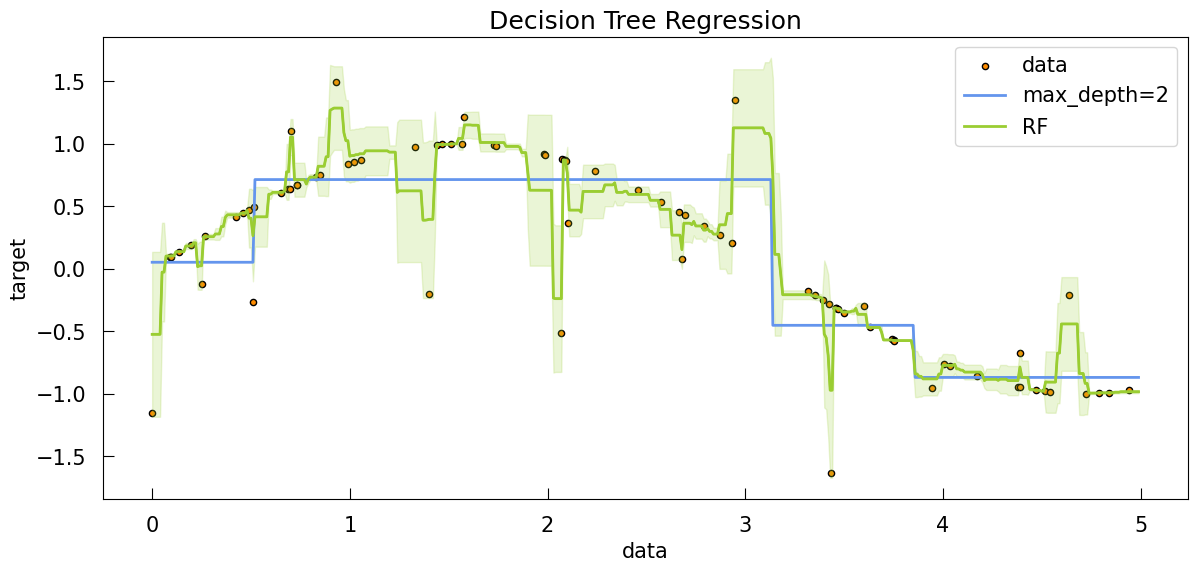

In [181]:

## collecting prediction from all individual trees in a big list
y_pred = []
x_pred = []
for tree in RFReg.estimators_ :
    y_pred += list( tree.predict(X_test) )
    x_pred += list(X_test[:,0])


plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
sns.lineplot(x=x_pred , y=y_pred , color="yellowgreen" , errorbar = 'sd') 
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


Let's try on the diabetes data:

In [182]:
X_diabetes_train.shape

(331, 10)

In [183]:
%%time
from sklearn.ensemble import RandomForestRegressor

## when it comes to criterion, we can now choose:
# * “squared_error” (default) for the mean squared error, minimizes the L2 loss
#                                           using the mean of each terminal node,
# * “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits
# * “absolute_error” for the mean absolute error, which minimizes the L1 loss
#                                           using the median of each terminal node,
# * “poisson” which uses reduction in Poisson deviance to find splits.
#
# let's try squared error and absolute error

grid_values = {'criterion': ['squared_error' , 'absolute_error'],
               'n_estimators':[500], 
               'max_depth':[2,4,8],
               'min_samples_split':np.arange(2,len(X_diabetes_train)//5,20),
              'min_samples_leaf':np.arange(2,len(X_diabetes_train)//5,20)}

grid_RF_diabetes = GridSearchCV(RandomForestRegressor(),
                                param_grid = grid_values, 
                                scoring='r2',n_jobs=-1,cv=5)

grid_RF_diabetes.fit(X_diabetes_train, y_diabetes_train)


print('Grid best score (r2): ', grid_RF_diabetes.best_score_)
print('Grid best parameter (max. r2): ', grid_RF_diabetes.best_params_)

Grid best score (r2):  0.43078447246620827
Grid best parameter (max. r2):  {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 22, 'n_estimators': 500}
CPU times: user 1.29 s, sys: 107 ms, total: 1.39 s
Wall time: 1min 32s


In [184]:
y_decision_fn_scores_RF_diabetes=grid_RF_diabetes.score(X_diabetes_test,y_diabetes_test)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_RF_diabetes)

Grid best parameter (max. r2) model on test:  0.5493005741523592


In [185]:
feature_importance_diabetes=grid_RF_diabetes.best_estimator_.feature_importances_

sorted_features=sorted([[df_diabetes.columns[i],abs(feature_importance_diabetes[i])] for i in range(len(feature_importance_diabetes))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
for f,w in sorted_features:
    print('{:>20}\t{:.3f}'.format(f,w))

Features sorted per importance in discriminative process
                  s5	0.407
                 bmi	0.364
                  bp	0.099
                  s3	0.037
                  s6	0.030
                 age	0.022
                  s2	0.019
                  s1	0.015
                  s4	0.006
                 sex	0.001


Tree-based techniques are interesting because:
 * they do not necessitate scaling
 * they give interpretable models and results
 * they model arbitrary non-linear problems
 
However as you have seen they tend to take longer to train...

[Back to the ToC](#toc)

# Gradient boosting tree <a class="anchor" id="Gradient"></a>

Gradient boosted is made for regression (you saw that already)! It is even simpler than what we saw before since you don't have to do all those transformations and just go for minimizing the MSE loss function. So let's check it out.

In [186]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# define the hyperparameters you want to test with their range
grid_values = {'learning_rate':np.logspace(-1,0,5),
               'n_estimators':np.arange(25,101,25), 
               'max_depth':[2,3,4],
               'min_samples_split':[10,20],
               'min_samples_leaf':[2,5]}

# Feed them to GridSearchCV with the right score (R squared)
grid_tree = GridSearchCV(GradientBoostingRegressor(), param_grid = grid_values, scoring='r2')

grid_tree.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores=grid_tree.score(X_diabetes_test,y_diabetes_test)


print('Grid best parameter (max. r2): ', grid_tree.best_params_)
print('Grid best score (r2): ', grid_tree.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores)

Grid best parameter (max. r2):  {'learning_rate': 0.1778279410038923, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 25}
Grid best score (r2):  0.4290845199990928
Grid best parameter (max. r2) model on test:  0.5380192947311326
CPU times: user 34.7 s, sys: 0 ns, total: 34.7 s
Wall time: 34.7 s


In [187]:
RFC = grid_tree.best_estimator_
    
featureW = pd.DataFrame( {'feature': diabetes['feature_names'],
                        'weight':RFC.feature_importances_} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )

Features sorted per importance:
  feature    weight
2     bmi  0.373461
8      s5  0.366582
3      bp  0.117270
6      s3  0.048118
9      s6  0.027981
0     age  0.018402
5      s2  0.018329
4      s1  0.017458
1     sex  0.012398


[Back to ToC](#toc)

# Exercise:  <a class="anchor" id="exo"></a>

Go back to the potato dataset and this time instead of classifying by type of color, predict the color directly.

> the model can take even longer than before to train. Be mindful of the parameter space you specify. For instance, if you use a polynomial : do you really want a 3rd degree polynomial exploring all combinations of 15000 genes ? How many parameters would that represent?
 Again, `SelectKBest`, and/or a preliminary PCA are your friend (use scores adapted to regression)

Try linear regression (with different degrees if you wish) and gradient boosting tree. What do you learn about Flesh Color?

In [188]:
df = pd.read_excel('../data/12859_2016_1043_MOESM1_ESM.xlsx' )
df.index = df.Genotype
df.head()

## color is encoded between 0 and 50. 
y = df["Flesh Colour"]

y.describe()


count    86.000000
mean     24.054824
std      13.023169
min       6.887500
25%      12.664600
50%      24.278800
75%      31.305050
max      57.035100
Name: Flesh Colour, dtype: float64

Now let's read the sheet containing the transcriptomic data. Thankfully it has already been normalized so we only have minor adjustments to perform.

In [189]:
xls = pd.ExcelFile('../data/12859_2016_1043_MOESM1_ESM.xlsx')
dfT = pd.read_excel(xls, 'Transcriptomics data ')

# transpose and keep only samples for which we have a target value
dfTT = dfT.T.loc[y.index , :]
dfTT.columns = dfT.loc[: , 'FeatureNum'].astype(str) 
dfTT.head()

FeatureNum,12,15,17,21,22,23,29,33,56,57,...,45166,45176,45182,45183,45187,45196,45203,45206,45208,45209
Genotype,,,,,,,,,,,,,,,,,,,,,
CE017,9.684237,7.620347,8.884715,6.561108,10.954142,7.942950,11.061238,12.516361,7.979206,6.255893,...,9.371388,9.351016,6.832953,6.531073,11.059569,9.158997,11.301824,6.534775,8.785558,11.938703
CE069,8.830570,8.296280,9.172465,5.928511,10.991732,8.670691,11.806689,12.606153,8.077820,6.672355,...,9.818819,9.138284,6.872256,6.219264,10.832024,8.952727,10.925734,5.659484,9.006652,11.778435
CE072,9.336937,7.786448,9.217694,6.264187,10.703214,8.257294,12.081581,11.620535,8.206966,6.049687,...,10.325439,9.014987,6.792484,7.103340,11.206071,8.785558,10.952507,5.608868,8.710704,12.149159
CE084,8.568445,7.682821,9.029574,6.273357,10.231839,8.652792,11.448696,12.043662,8.043799,6.613981,...,10.646100,9.182161,6.739931,6.401386,10.768311,8.602304,10.999588,6.643213,9.211117,11.956719
CE110,9.148615,7.417268,5.962352,6.668078,10.170824,7.661002,11.062998,12.262134,8.253087,6.492964,...,9.586301,9.175210,6.818788,6.192561,11.385558,8.459614,10.984700,6.676830,8.789405,11.792416


separate train and test sets

In [190]:
# %load -r 1-6 solutions/solution_04_potato.py

finding the best linear model

In [191]:
# %load -r 8-43 solutions/solution_04_potato.py
%%time
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from operator import itemgetter
from sklearn.feature_selection import f_regression


# Linear model fitted by minimizing a regularized empirical loss with SGD (Stochastic gradient Descent)
lr_reg_P=SGDRegressor()


pipeline_lr_reg_P=Pipeline([('selectk',SelectKBest(f_regression)),
                          ('poly',PolynomialFeatures()),
                          ('scalar',StandardScaler()),
                          ('model',lr_reg_P)])

from sklearn.model_selection import GridSearchCV

# define the hyperparameters you want to test with their range
grid_values = {'selectk__k':np.arange(100,901,200),
               'poly__degree': [1],#np.arange(1,4,1),
               'model__penalty':['l1','l2'],
               'model__alpha':np.logspace(-1,1,3)}

# Feed them to GridSearchCV with the right score (R squared)
grid_lr_reg_P = GridSearchCV(pipeline_lr_reg_P, param_grid = grid_values, scoring='r2',n_jobs=-1)

grid_lr_reg_P.fit(X_train, y_train)



# get the best parameters
print('Grid best parameter (max. r2): ', grid_lr_reg_P.best_params_)
#get the best score calculated from the train/validation dataset
print('Grid best score (r2): ', grid_lr_reg_P.best_score_)


UsageError: Line magic function `%%time` not found.


finding the best SVR

In [ ]:
# %load -r 44-75 solutions/solution_04_potato.py

finding the best gradient boosting tree

In [ ]:
# %load -r 76-100 solutions/solution_04_potato.py

choosing the best method 

In [ ]:
# %load -r 103-105 solutions/solution_04_potato.py

In [ ]:
# %load -r 107-121 solutions/solution_04_potato.py

looking at feature importance

In [ ]:
# %load -r 122- solutions/solution_04_potato.py